## Dependencies

In [1]:
import sys
import os
root_dir = os.path.abspath(os.path.join(os.getcwd(), ".."))
sys.path.append(root_dir)
from pathlib import Path

import torch

from models import tiramisu_nclasses
import src.training as train_utils
from src.imgs import ImgToolkit
from src import tools

In [2]:
from datasets.inference_dataset import InferenceDataset
from datasets.floodnet import Dataset

In [3]:
tools.total_mem(), tools.free_mem(), tools.mem()

((125.79545593261719, 14.56805419921875),
 (119.89093780517578, 14.56805419921875),
 (4.266544342041016, 0.0))

In [4]:
# dataset_folder='/outputs/RescueNet-resized-713/semanticSegmentationTestSet/test-org-img'
dataset_folder='/outputs/airflow_data/floodnet/img-4000'
dataset_folder='/outputs/airflow_data/floodnet/img-700'
infererence_dataset = InferenceDataset(Dataset_model=Dataset, dataset_folder=dataset_folder)
len(infererence_dataset)

383

In [5]:
t = ImgToolkit(Dataset)

In [6]:
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = 'cuda' 

In [7]:
# weights_file = Path(root_dir) / '.weights' / 'adam_sched' / 'weights-395.pth'
weights_file = Path(root_dir) / '.weights' / 'fn_tl' / 'weights-200.pth'
weights = torch.load(weights_file, map_location=device)
model = tiramisu_nclasses.FCDenseNet103(len(infererence_dataset.class_names)).to(device)
model.load_state_dict(weights['state_dict'])

<All keys matched successfully>

In [8]:
dataloader = torch.utils.data.DataLoader(
    infererence_dataset, batch_size=1, shuffle=False)

In [9]:
tools.total_mem(), tools.free_mem(), tools.mem()

((125.79545593261719, 14.56805419921875),
 (119.75457000732422, 14.49749755859375),
 (4.393146514892578, 0.070556640625))

In [10]:
tools.memprint('baseline')

baseline
 4.39 / 0.07


In [11]:
torch.cuda.empty_cache()

# Print initial memory
tools.memprint("Before loading batch:")


model.eval()
with torch.no_grad():
    batch = next(iter(dataloader)).to(device)
    output = model(batch)

    tools.memprint("After loading 1 batch:")


Before loading batch:
 4.39 / 0.07
After loading 1 batch:
 4.51 / 0.10


In [13]:
output.shape

torch.Size([1, 10, 700, 933])

In [13]:
pred = train_utils.get_predictions(output)
pred.shape

torch.Size([1, 700, 933])

In [15]:
tools.memprint('now')

now
 18.28 / 0.04


In [ ]:
for i, batch in enumerate(dataloader):
    print(f"Processing batch {i}")
    print(batch.shape)


In [ ]:
tools.mem(), tools.total_mem(), tools.free_mem()

((4.8331756591796875, 0.03572845458984375),
 (125.79545593261719, 14.56805419921875),
 (119.3173713684082, 14.532325744628906))

### input image from a Dataset


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-5.556080917568096e-08..1.0000000127921906].


input.shape torch.Size([1, 3, 713, 950])


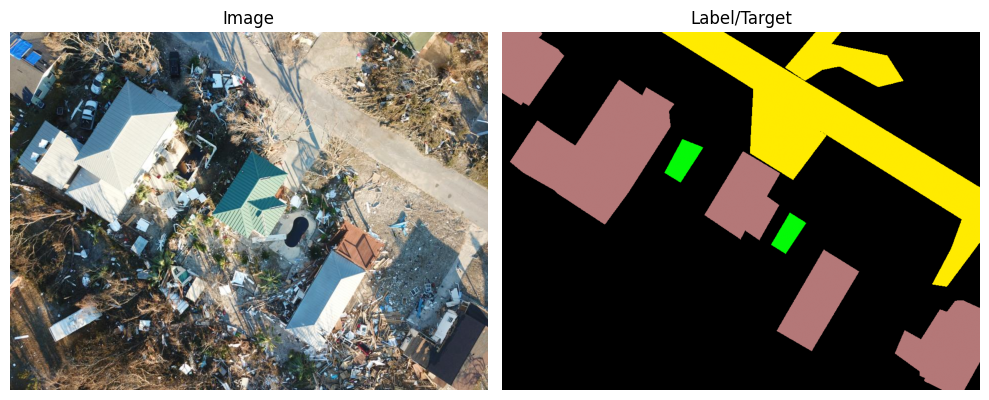

In [11]:
# import the dataset
from datasets.rescuenet_resized import Dataset
d = Dataset(split='test', scale=713)


# choose the image index
n=117



input = d[n][0].unsqueeze(0)
print(f"input.shape {input.shape}")

t = ImgToolkit(d)

t.view(n)
               

### or provide a file as input image

In [4]:
# def prepare(img_path, Dataset):
#     img = Dataset.loader(img_path)
#     #img = ImageOps.exif_transpose(img) 
#     img = Dataset.transform(img)
#     return img


## image path
# input_image = 'image_path'

# input = prepare(input_image, exp.Dataset())
# input = input.unsqueeze(0)
# print(f"input.shape {input.shape}")


# t = ImgToolkit(exp.Dataset())

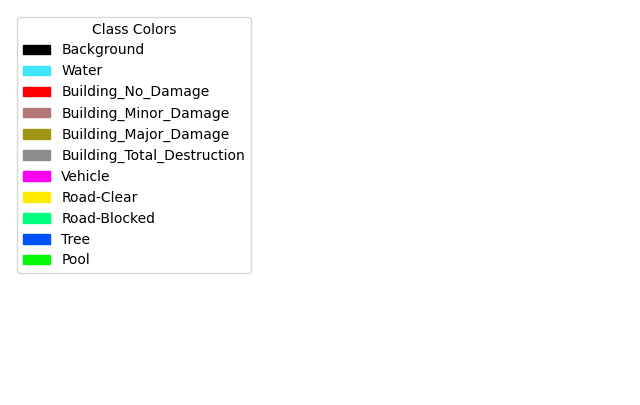

In [5]:
t.print_dataset_colors()


### calculating the mask

In [6]:

output = model(input)
output.shape
pred = train_utils.get_predictions(output)
pred = pred.squeeze()
pred.shape

torch.Size([713, 950])

In [7]:
input=input.squeeze()
img = t.img_to_np(input)

target = t.label_to_np(pred)
print(img.shape, target.shape)


(713, 950, 3) (713, 950, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-5.556080917568096e-08..1.0000000127921906].


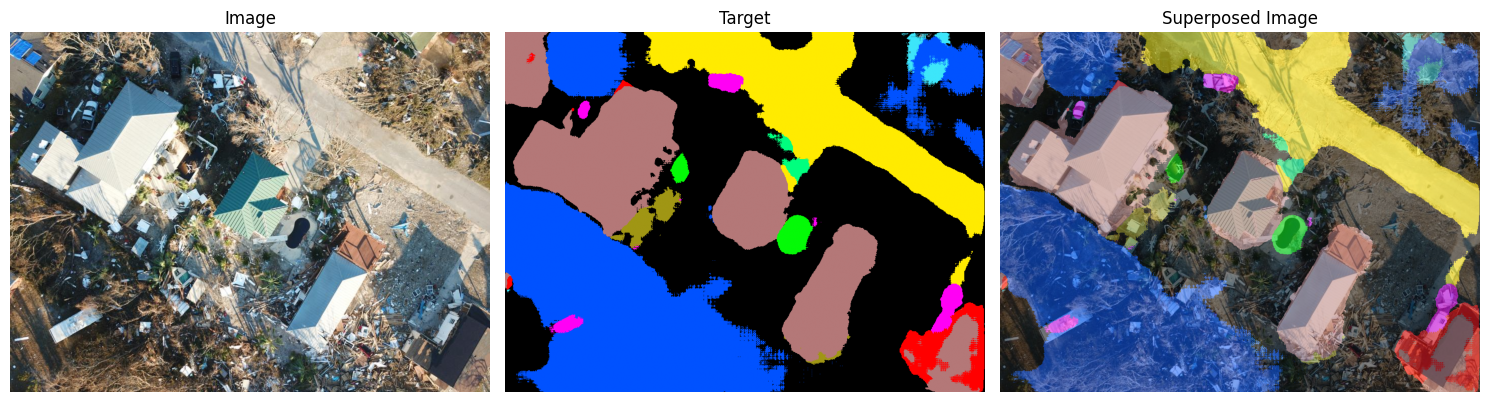

In [8]:

t.visualize_images_with_superposition(img, target, alpha=0.5)